### **Notebook to make predictions with reprocessed Yoneda data and EFLUX2 and SPOT** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_yoneda_set3_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [4]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14400,Biodesign_Yoneda_set3_reprocessed,15006,EVOL33-LN-G-R1,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15030,EVOL33-LN-G-R1,NaN,WP_000104864_1,0,FPKM,0.0,14.0
1,14400,Biodesign_Yoneda_set3_reprocessed,15007,EVOL33-LN-G-R2,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15031,EVOL33-LN-G-R2,NaN,WP_000104864_1,0,FPKM,0.0,14.0
2,14400,Biodesign_Yoneda_set3_reprocessed,15008,EVOL33-LN-G-R3,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15032,EVOL33-LN-G-R3,NaN,WP_000104864_1,0,FPKM,0.0,14.0
3,14400,Biodesign_Yoneda_set3_reprocessed,14991,EVOL33-LN-LP-R1,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15015,EVOL33-LN-LP-R1,NaN,WP_000104864_1,0,FPKM,0.0,24.0
4,14400,Biodesign_Yoneda_set3_reprocessed,14992,EVOL33-LN-LP-R2,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15016,EVOL33-LN-LP-R2,NaN,WP_000104864_1,0,FPKM,0.0,24.0


##### **Load Genome Scale Model**

In [5]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [6]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2,SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [7]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(transdata, linename, conditionstring):
    transdataPhe = transdata[transdata['Line Description'].str.contains(conditionstring)]
    transdataWTPR1 = transdataPhe[transdataPhe['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

#### **EFLUX2 Predictions**

In [11]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = 100.0#sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = 100.0#sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)
        #spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol#, spotsol

In [12]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

##### **Wild Type**

In [13]:
eflux2sol, eflux2sol_std = eflux2predthreereps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')

FBA status optimal
FBA solution 0.6189480042770429


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.6189480042770429


EFlux2 status optimal
EFlux2 solution 6061.0324530813


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 0.2103749195934234


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.2103749195934234


EFlux2 status optimal
EFlux2 solution 501.04154585982405


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 0.5044710616634364


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.5044710616634364


EFlux2 status optimal
EFlux2 solution 4746.058023614523


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [14]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

In [15]:
df_new=eflux2soldf[eflux2soldf['fluxes']==1000000]
display(df_new)

,fluxes


In [16]:
eflux2soldf.loc['EX_glc__D_e',:]

fluxes   -7.692805
Name: EX_glc__D_e, dtype: float64

##### **Check External Metabolites solution**

In [17]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [18]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes   -7.692805
Name: EX_glc__D_e, dtype: float64

fluxes    25.397693
Name: EX_h2o_e, dtype: float64

fluxes    7.151126
Name: EX_h_e, dtype: float64

fluxes    1.080847
Name: EX_ala__L_e, dtype: float64

fluxes   -0.002247
Name: EX_cl_e, dtype: float64

fluxes    2.294863
Name: EX_acald_e, dtype: float64

fluxes   -0.707934
Name: EX_pi_e, dtype: float64

fluxes   -7.813148
Name: EX_nh4_e, dtype: float64

fluxes    0.945514
Name: EX_ala__D_e, dtype: float64

fluxes   -0.00337
Name: EX_fe3_e, dtype: float64

fluxes   -0.084253
Name: EX_k_e, dtype: float64

fluxes   -0.002247
Name: EX_ca2_e, dtype: float64

fluxes   -0.003744
Name: EX_mg2_e, dtype: float64

fluxes   -0.000298
Name: EX_mn2_e, dtype: float64

fluxes   -0.000147
Name: EX_zn2_e, dtype: float64

fluxes    0.040514
Name: EX_succ_e, dtype: float64

fluxes    10.404635
Name: EX_co2_e, dtype: float64

fluxes   -0.000306
Name: EX_cu2_e, dtype: float64

fluxes   -7.485816
Name: EX_o2_e, dtype: float64

fluxes   -0.002898
Name: EX_fe2_e, dtype: float64

fluxes   -0.06728
Name: EX_so4_e, dtype: float64

fluxes    1.822086
Name: EX_val__L_e, dtype: float64

##### **Check FBA solution**

In [19]:
with model:
    medium = model.medium
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    #medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = 0#sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.7933023386368265


##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [20]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 32 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [21]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [22]:
def scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'], dtype=np.float64)
    scalepred_fluxes = pd.DataFrame(index=predictions.index, columns= ['fluxes'], dtype=np.float64)
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:   
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [23]:
def addpredfluxes_to13cdf(observed_fluxes, predictions, stdpredictions, substrate, method):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [24]:
obspred_fluxes = addpredfluxes_to13cdf(glucose_fluxes, eflux2soldf, eflux2solstddf, 'glucose', 'EFLUX2')

In [25]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-6.505469e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,6.432021e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,2.643882e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,2.643882e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,5.909743e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,1.193962e+02
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,-1.193962e+02
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,-1.492140e-13
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,169.334371,1.156743e+02
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-163.434935,-1.126928e+02


### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [26]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, linename):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

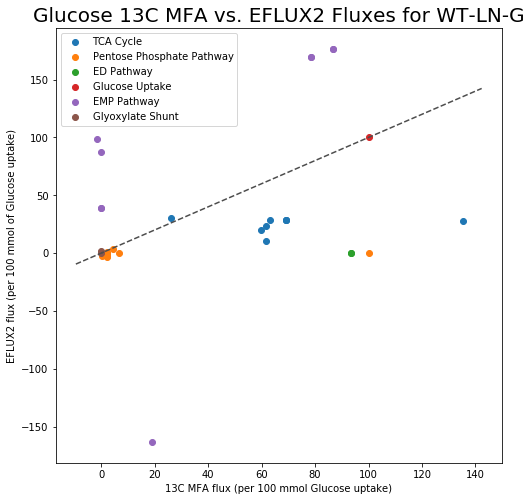

In [27]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G')

##### **Plot observations vs. predictions with confidence intervals**

In [28]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, linename):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

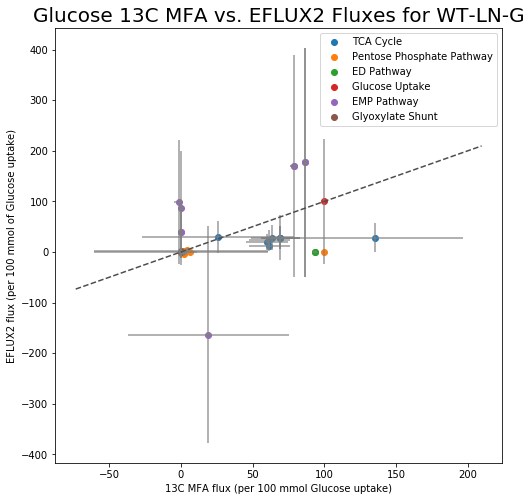

In [29]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G')

##### **EVOL33-LN-G**

In [31]:
eflux2sol_evol33, eflux2sol_std_evol33 = eflux2predthreereps(model, df_Trans, 'EVOL33-LN-G-R1', 'EVOL33-LN-G-R2','EVOL33-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.513461195241949


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.513461195241949


EFlux2 status optimal
EFlux2 solution 4529.0467839849325


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 1.064070665324433


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 1.064070665324433


EFlux2 status optimal
EFlux2 solution 35378.080499310076


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 0.6680123100906015


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.6680123100906015


EFlux2 status optimal
EFlux2 solution 10008.896470951875


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [32]:
eflux2soldf_evol33 = pd.DataFrame(eflux2sol_evol33, columns=['fluxes'])
eflux2solstddf_evol33 = pd.DataFrame(eflux2sol_std_evol33, columns=['stds'])

In [96]:
##### Check if any of the sols at the new set bound

In [33]:
df_new2 = eflux2soldf_evol33[eflux2soldf_evol33['fluxes']==1000000]
display(df_new2)

,fluxes


##### **Check External Metabolites solution**

In [34]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [35]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes   -7.692805
Name: EX_glc__D_e, dtype: float64

fluxes    25.397693
Name: EX_h2o_e, dtype: float64

fluxes    7.151126
Name: EX_h_e, dtype: float64

fluxes    1.080847
Name: EX_ala__L_e, dtype: float64

fluxes   -0.002247
Name: EX_cl_e, dtype: float64

fluxes    2.294863
Name: EX_acald_e, dtype: float64

fluxes   -0.707934
Name: EX_pi_e, dtype: float64

fluxes   -7.813148
Name: EX_nh4_e, dtype: float64

fluxes    0.945514
Name: EX_ala__D_e, dtype: float64

fluxes   -0.00337
Name: EX_fe3_e, dtype: float64

fluxes   -0.084253
Name: EX_k_e, dtype: float64

fluxes   -0.002247
Name: EX_ca2_e, dtype: float64

fluxes   -0.003744
Name: EX_mg2_e, dtype: float64

fluxes   -0.000298
Name: EX_mn2_e, dtype: float64

fluxes   -0.000147
Name: EX_zn2_e, dtype: float64

fluxes    0.040514
Name: EX_succ_e, dtype: float64

fluxes    10.404635
Name: EX_co2_e, dtype: float64

fluxes   -0.000306
Name: EX_cu2_e, dtype: float64

fluxes   -7.485816
Name: EX_o2_e, dtype: float64

fluxes   -0.002898
Name: EX_fe2_e, dtype: float64

fluxes   -0.06728
Name: EX_so4_e, dtype: float64

fluxes    1.822086
Name: EX_val__L_e, dtype: float64

##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [36]:
obspred_fluxes2 = addpredfluxes_to13cdf(obspred_fluxes, eflux2soldf_evol33, eflux2solstddf_evol33, 'glucose', 'EFLUX2')

In [37]:
obspred_fluxes2

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-5.620135e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.902692,5.578503e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,42.054199,2.737500e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,42.054199,2.737500e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,91.079022,5.281669e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,183.961714,1.063177e+02
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,183.961714,-1.063177e+02
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,175.889250,8.526513e-14
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,175.889250,1.019336e+02
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-173.485716,-1.037734e+02


#### Plot EFLUX2 vs 13C MFA

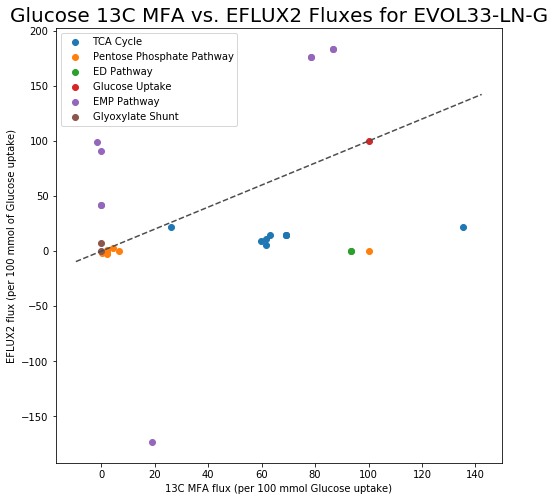

In [38]:
scatterplotcomp_obs_vs_pred(obspred_fluxes2, substrate='glucose', method='EFLUX2', linename='EVOL33-LN-G')

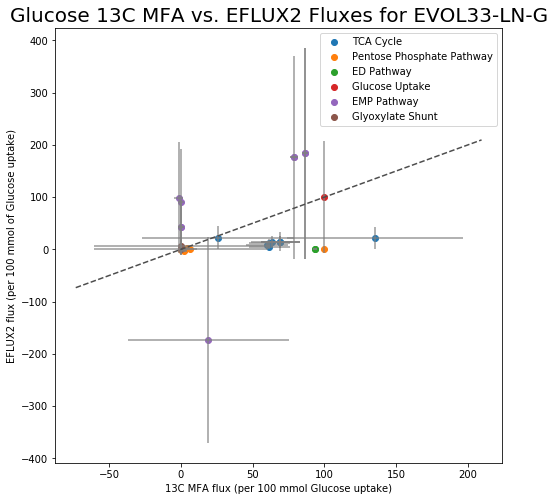

In [39]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes2, substrate='glucose', method='EFLUX2',linename='EVOL33-LN-G')

##### **EVOL40-LN-G**

In [40]:
fva_result = cobra.flux_analysis.flux_variability_analysis(
    model, model.reactions)
pd.DataFrame.from_dict(fva_result).T.round(5)

,12DGR120tipp,12DGR140tipp,12DGR141tipp,12DGR161tipp,12DGR180tipp,12DGR181tipp,12PPDStpp,12PPDt,14GLUCANabcpp,14GLUCANtexi,...,sink_bmocogdp_c,sink_lipopb_c,sink_sheme_c,Growth,ATPM,EX_phenol_e,phenol_transport,PHEMOX,Growth_Phenol,Growth_Glucose
minimum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0
maximum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
eflux2sol_evol40, eflux2sol_std_evol40 = eflux2predthreereps(model, df_Trans, 'EVOL40-LN-G-R1', 'EVOL40-LN-G-R2','EVOL40-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.7564651818190398


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.7564651818190398


EFlux2 status optimal
EFlux2 solution 15441.907296622316


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 0.2679175683521312


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.2679175683521312


EFlux2 status optimal
EFlux2 solution 812.6212938600786


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

FBA status optimal
FBA solution 0.39491889684257026


Problem infeasible or unbounded: to be added value for transbound will be set to  1000000.0  instead of np.inf
FBA status optimal
FBA solution 0.39491889684257026


EFlux2 status optimal
EFlux2 solution 2094.5328792748805


{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [42]:
eflux2soldf_evol40 = pd.DataFrame(eflux2sol_evol40, columns=['fluxes'])
eflux2solstddf_evol40 = pd.DataFrame(eflux2sol_std_evol40, columns=['stds'])

In [43]:
df_new3=eflux2soldf_evol40[eflux2soldf_evol40['fluxes']==1000000]
display(df_new3)

,fluxes


##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [44]:
obspred_fluxes3 = addpredfluxes_to13cdf(obspred_fluxes, eflux2soldf_evol40, eflux2solstddf_evol40, 'glucose', 'EFLUX2')

In [45]:
obspred_fluxes3

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02


#### Plot EFLUX2 vs 13C MFA

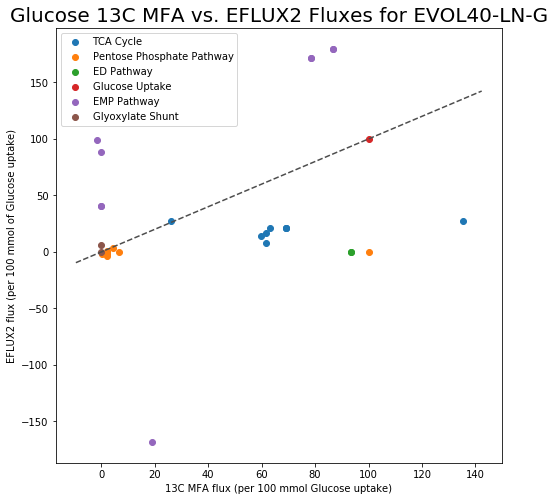

In [46]:
scatterplotcomp_obs_vs_pred(obspred_fluxes3, substrate='glucose', method='EFLUX2',linename='EVOL40-LN-G')

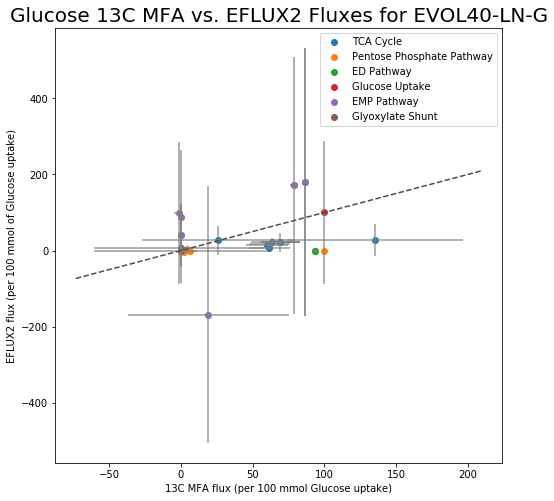

In [47]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes3, substrate='glucose', method='EFLUX2', linename='EVOL40-LN-G')

#### Glucose EFlux Flux Map

Define a function to convert a predicted flux data frame column to a flux map

In [48]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if pd.isnull(row['Location on map'])!=True:
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)
    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

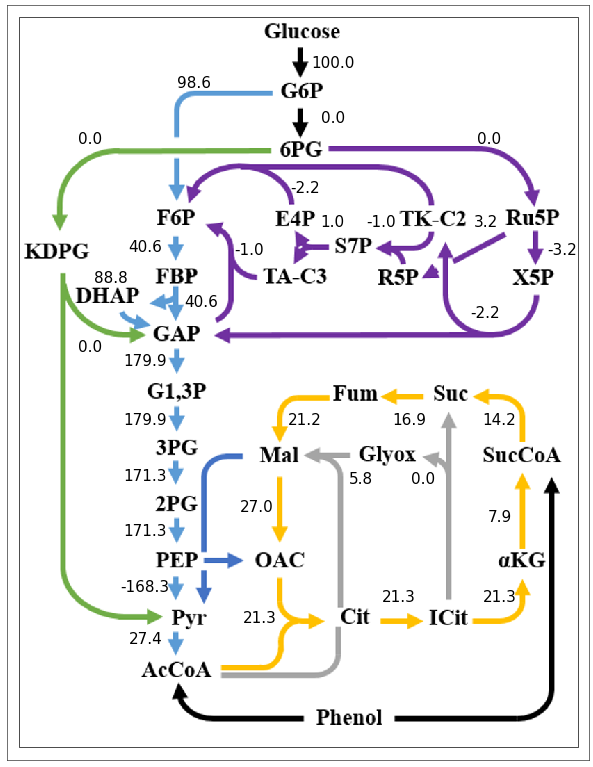

In [49]:
map_flux_results(obspred_fluxes, 'EFLUX2 Value')

#### **SPOT Predictions**

In [50]:
#Function for EFLUX2 and SPOT Predictions:
def spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:np.inf for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
    return spotsol#, spotsol

In [51]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    spotsol_R1 = spotpred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    spotsol_R2 = spotpred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    spotsol_R3 = spotpred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [52]:
spotsol, spotsol_std = spotpredthreereps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [53]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

##### **Check External Metabolites solution**

In [54]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [55]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes   -0.008909
Name: EX_glc__D_e, dtype: float64

fluxes    0.034701
Name: EX_h2o_e, dtype: float64

fluxes    0.012698
Name: EX_h_e, dtype: float64

fluxes    0.000181
Name: EX_nh4_e, dtype: float64

fluxes    0.006419
Name: EX_succ_e, dtype: float64

fluxes    0.028942
Name: EX_co2_e, dtype: float64

fluxes   -0.032178
Name: EX_o2_e, dtype: float64

##### **Check FBA solution**

In [56]:
with model:
    medium = model.medium
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    #medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = 0.0#sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)
    

Unbounded FBA status optimal
Unbounded FBA solution 0.7933023386368266


##### **Add  Glucose EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [57]:
obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf, spotsolstddf, 'glucose', 'SPOT')

In [58]:
obspred_fluxesnew

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01,100.000000,-48.475087
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01,100.217639,48.323901
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01,70.312063,29.704238
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01,70.284709,29.712858
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01,100.838921,47.777693
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02,201.747662,95.474067
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02,201.747662,-95.474067
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13,201.776650,-15.525125
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02,201.945835,95.287864
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02,-194.472756,-108.093211


#### Plot SPOT vs 13C MFA

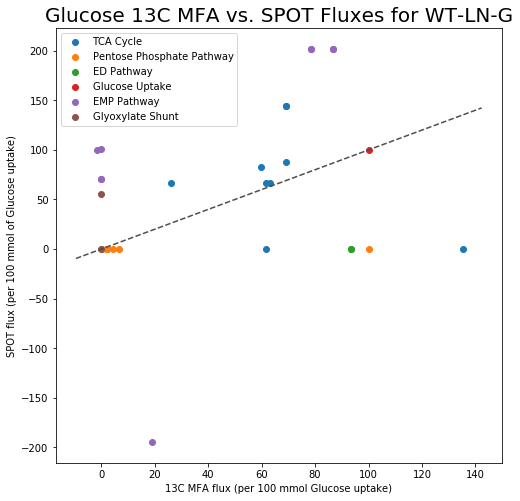

In [59]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew, substrate='glucose', method='SPOT', linename='WT-LN-G')

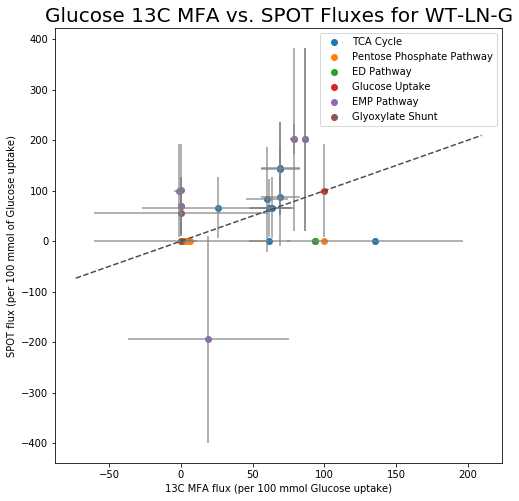

In [60]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew, substrate='glucose', method='SPOT',linename='WT-LN-G')

##### **EVOL33-LN-G**

In [61]:
fva_result = cobra.flux_analysis.flux_variability_analysis(
    model, model.reactions)
pd.DataFrame.from_dict(fva_result).T.round(5)

,12DGR120tipp,12DGR140tipp,12DGR141tipp,12DGR161tipp,12DGR180tipp,12DGR181tipp,12PPDStpp,12PPDt,14GLUCANabcpp,14GLUCANtexi,...,sink_bmocogdp_c,sink_lipopb_c,sink_sheme_c,Growth,ATPM,EX_phenol_e,phenol_transport,PHEMOX,Growth_Phenol,Growth_Glucose
minimum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0
maximum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
spotsol_evol33, spotsol_std_evol33 = spotpredthreereps(model, df_Trans, 'EVOL33-LN-G-R1', 'EVOL33-LN-G-R2','EVOL33-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [63]:
spotsoldf_evol33 = pd.DataFrame(spotsol_evol33, columns=['fluxes'])
spotsolstddf_evol33 = pd.DataFrame(spotsol_std_evol33, columns=['stds'])

##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [64]:
obspred_fluxesnew2 = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf_evol33, spotsolstddf_evol33, 'glucose', 'SPOT')

In [65]:
obspred_fluxesnew2

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01,100.000000,-4.358105e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01,100.081946,4.355998e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01,70.037067,2.711702e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01,70.025613,2.712118e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01,100.312146,4.346881e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02,200.660861,8.690385e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02,200.660861,-8.690385e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13,200.657114,-1.478254e+01
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02,200.730419,8.685605e+01
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02,-198.421470,-9.061810e+01


#### Plot SPOT vs 13C MFA

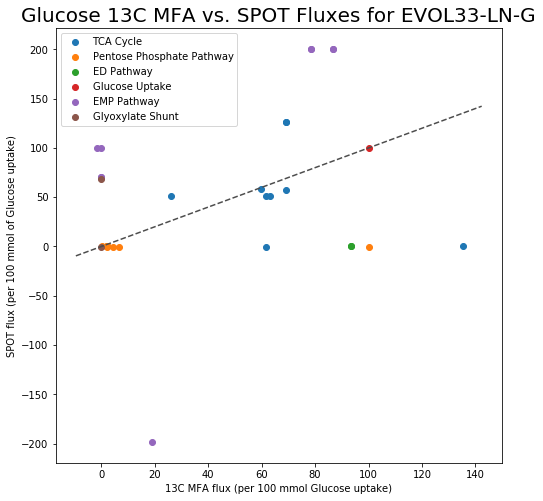

In [66]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew2, substrate='glucose', method='SPOT', linename='EVOL33-LN-G')

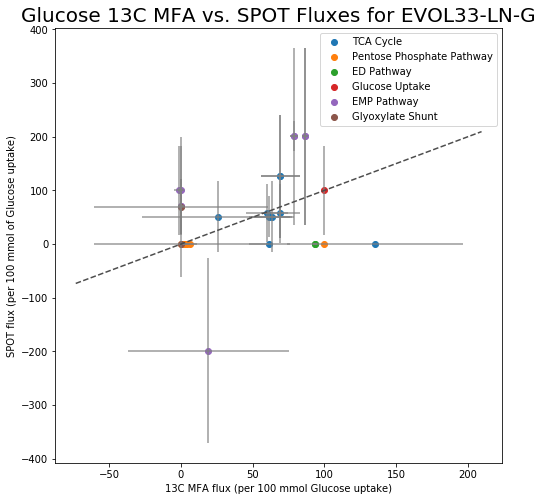

In [67]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew2, substrate='glucose', method='SPOT',linename='EVOL33-LN-G')

##### **EVOL40-LN-G**

In [68]:
fva_result = cobra.flux_analysis.flux_variability_analysis(
    model, model.reactions)
pd.DataFrame.from_dict(fva_result).T.round(5)

,12DGR120tipp,12DGR140tipp,12DGR141tipp,12DGR161tipp,12DGR180tipp,12DGR181tipp,12PPDStpp,12PPDt,14GLUCANabcpp,14GLUCANtexi,...,sink_bmocogdp_c,sink_lipopb_c,sink_sheme_c,Growth,ATPM,EX_phenol_e,phenol_transport,PHEMOX,Growth_Phenol,Growth_Glucose
minimum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0
maximum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.79162,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
spotsol_evol40, spotsol_std_evol40 = spotpredthreereps(model, df_Trans, 'EVOL40-LN-G-R1', 'EVOL40-LN-G-R2','EVOL40-LN-G-R3', 'glucose', 100, '1.0 g/l glucose as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

##### **Save solution to data frame**

In [70]:
spotsoldf_evol40 = pd.DataFrame(spotsol_evol40, columns=['fluxes'])
spotsolstddf_evol40 = pd.DataFrame(spotsol_std_evol40, columns=['stds'])

##### **Add  Glucose EVOL40 EFLUX2 and SPOT flux values to glucose fluxes dataframe**

In [71]:
obspred_fluxesnew3 = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf_evol40, spotsolstddf_evol40, 'glucose', 'SPOT')

In [72]:
obspred_fluxesnew3

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01,100.000000,-1.638711e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01,100.043618,1.639826e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01,71.187949,9.123239e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01,71.183429,9.123195e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01,100.154614,1.641309e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02,200.320168,3.282134e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02,200.320168,-3.282134e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13,200.292671,-3.030513e+00
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02,200.318635,3.277494e+01
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02,-187.811616,-4.173123e+01


#### Plot SPOT vs 13C MFA

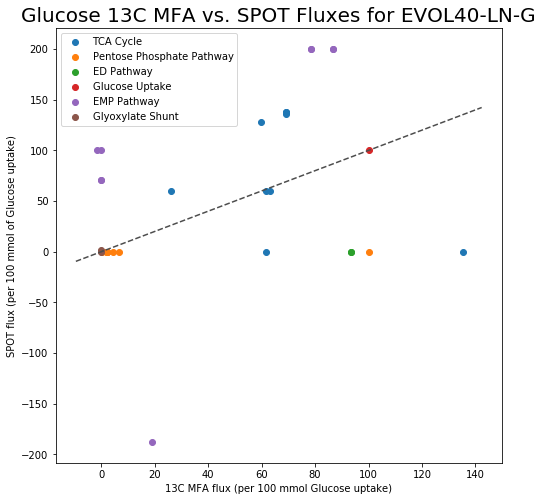

In [73]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew3, substrate='glucose', method='SPOT',linename='EVOL40-LN-G')

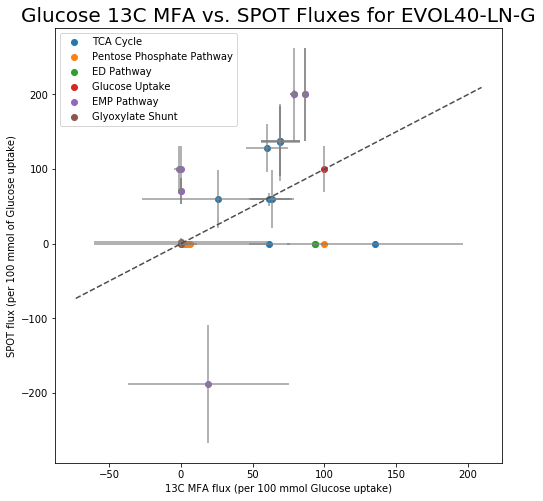

In [74]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew3, substrate='glucose', method='SPOT', linename='EVOL40-LN-G')

### Map glucose SPOT fluxes

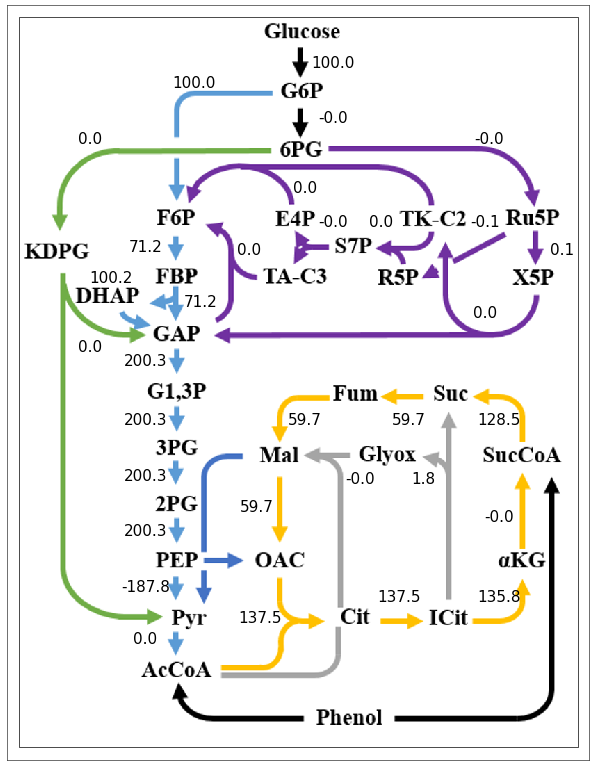

In [75]:
map_flux_results(obspred_fluxes, 'SPOT Value')

### Run glucose flux FBA

In [76]:
with model:
    model.objective = 'Growth_Glucose'
    mediumglu = model.medium
    
    # This is to prevent medium components other than phenol from being growth limitations
    mediumglu = {key:np.inf for (key,value) in model.medium.items()}
    
    mediumglu["EX_glc__D_e"] = 100.0
    mediumglu["EX_phenol_e"] = 0.0
    
    model.medium = mediumglu
#     print(model.medium)
    solutionglu = model.optimize()
    
print(solutionglu)

<Solution 11.824 at 0x7f2f978346d0>


### Add Glucose FBA flux values to test_df 

In [77]:
# fbasoldf = pd.DataFrame(solutionphe, columns=['fluxes'])

In [78]:
# obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, solutionphe, None, 'phenol', 'FBA')

In [79]:
FBA_fluxes_glu = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_glu = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_glu += min([get_flux_value(v, solutionglu) for v in and_split])
    FBA_fluxes_glu.append(flux_value_glu)
    
glucose_fluxes['FBA Value'] = FBA_fluxes_glu
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01,100.000000,-1.638711e+01,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01,100.043618,1.639826e+01,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01,71.187949,9.123239e+00,83.659664
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01,71.183429,9.123195e+00,83.659664
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01,100.154614,1.641309e+01,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02,200.320168,3.282134e+01,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02,200.320168,-3.282134e+01,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13,200.292671,-3.030513e+00,138.989792
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02,200.318635,3.277494e+01,138.989792
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02,-187.811616,-4.173123e+01,-131.866120


### Get r<sup>2</sup>  values 

In [97]:
# remove Energy molecule reactions as they are outliers
r_squared_df = glucose_fluxes[~glucose_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]


_, _, EFlux_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['EFLUX2 Value'])
_, _, Spot_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['SPOT Value'])
_, _, FBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['FBA Value'])

print(f'E-Flux2 vs 13C-MFA r-squared: {EFlux_r**2:.4F}')
print(f'SPOT vs 13C-MFA r-squared: {Spot_r**2:.4F}')
print(f'FBA vs 13C-MFA r-squared: {FBA_r**2:.4F}')

E-Flux2 vs 13C-MFA r-squared: 0.1157
SPOT vs 13C-MFA r-squared: 0.1411
FBA vs 13C-MFA r-squared: 0.1561


In [81]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-9.821687e+01,100.000000,-1.638711e+01,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.624873,9.748162e+01,100.043618,1.639826e+01,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,40.597578,4.355453e+01,71.187949,9.123239e+00,83.659664
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,40.597578,4.355453e+01,71.183429,9.123195e+00,83.659664
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,88.820387,9.224010e+01,100.154614,1.641309e+01,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,179.901101,1.856885e+02,200.320168,3.282134e+01,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,179.901101,-1.856885e+02,200.320168,-3.282134e+01,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,171.304628,2.984279e-13,200.292671,-3.030513e+00,138.989792
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,171.304628,1.777088e+02,200.318635,3.277494e+01,138.989792
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",19.02,-10.89,75.15,-168.292561,-1.774478e+02,-187.811616,-4.173123e+01,-131.866120


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

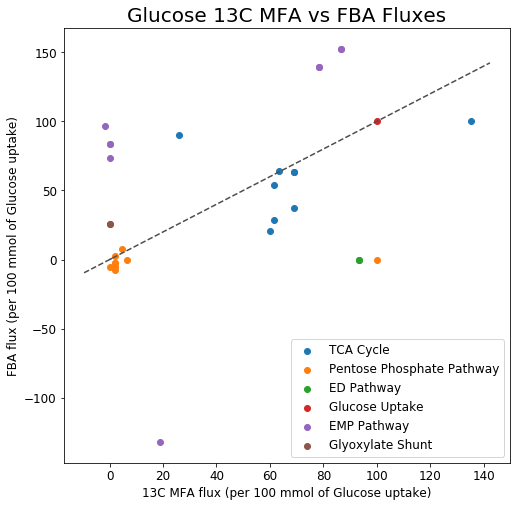

In [82]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Glucose 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Glucose uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of Glucose uptake)')
plt.legend()
plt.show()

### Map FBA Fluxes

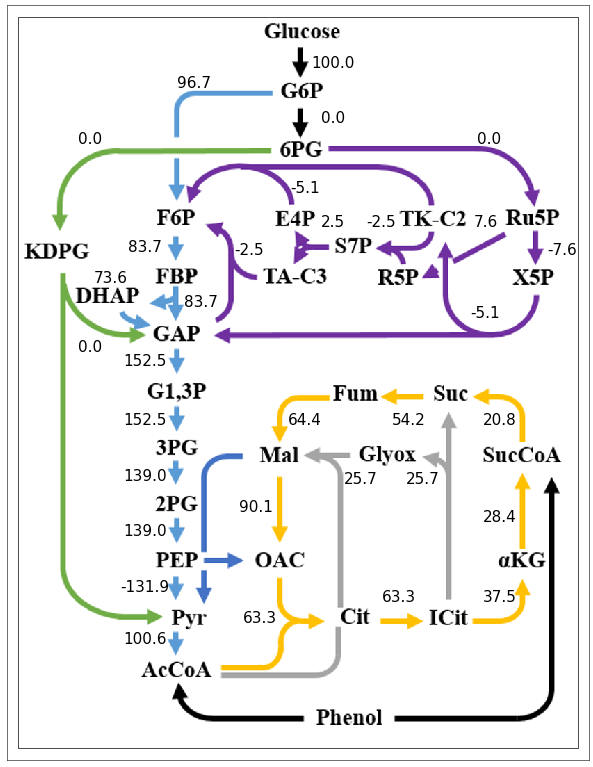

In [83]:
map_flux_results(obspred_fluxes, 'FBA Value')

### Map 13C MFA Fluxes

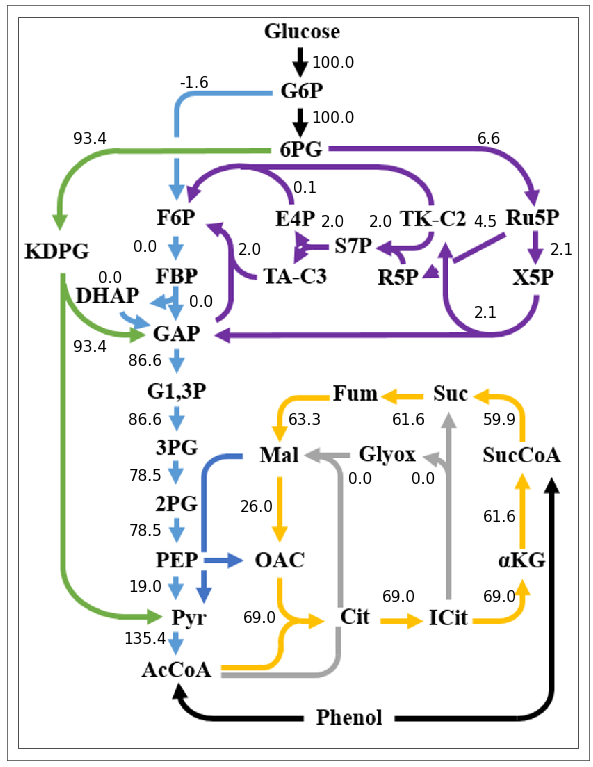

In [84]:
map_flux_results(obspred_fluxes, 'Flux')

#### Load observed growth rates and plot glucose growth rates

In [85]:
growthandsubstrdata = pd.read_csv('growthandsubstratedata.csv')

In [87]:
growthandsubstrdata
growthandsubstrdata.index = growthandsubstrdata['Unnamed: 0']
growthandsubstrdata.drop(['Unnamed: 0'], axis=1)

,growth_rate,yield_coeff,substrate_consumption_rate,growth_rate_std,yield_coeff_std,substr_cons_rate_std,FBA_growth_rate,pFBA_growth_rate
Unnamed: 0,,,,,,,,
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269,0.063811,0.063811
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354,0.092074,0.092074
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558,0.085679,0.085679
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000,0.003081,0.003081
EVOL33-HN-G,0.031149,1.183217,0.026325,0.000000,0.000000,0.000000,0.003113,0.003113
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000,0.059478,0.003113
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000,0.002392,0.002392
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000,0.003660,0.003660
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000,0.001893,0.001893


In [88]:
growthandsubstrdata.index
growthandsubstrdata.loc['WT-HN-HP', 'growth_rate']

0.018807910254428392

In [89]:
allgrowthrates=pd.DataFrame(index=['WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], columns=['Growth_Glucose_EFLUX2','Growth_Glucose_SPOT' ], dtype=float)
allgrowthrates.at['WT-LN-G','Growth_Glucose_SPOT'] = spotsoldf.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL33-LN-G','Growth_Glucose_SPOT'] = spotsoldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL40-LN-G','Growth_Glucose_SPOT'] = spotsoldf_evol40.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['WT-LN-G','Growth_Glucose_EFLUX2'] = eflux2soldf.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL33-LN-G','Growth_Glucose_EFLUX2'] = eflux2soldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL40-LN-G','Growth_Glucose_EFLUX2'] = eflux2soldf_evol40.loc['Growth_Glucose',:].values[0]
allgrowthrates

,Growth_Glucose_EFLUX2,Growth_Glucose_SPOT
WT-LN-G,0.444598,-1.562679e-06
EVOL33-LN-G,0.748515,-8.883902e-07
EVOL40-LN-G,0.473101,-5.104601e-07


In [94]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.5], [0.0, 0.5], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    display(tss)
    if tss>=1e-6:
        r2_1 = round(1 - rss / tss,2)
    else:
        r2_1 = round(1 - rss/tss,2)#####?????
    display(set(observed))
    display(type(observed))
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = round(maefunc(observed, predicted),2)
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

5.682206113215002e-13

{0.03274146524523911, 0.03415608108999895, 0.0390042421029697}

pandas.core.series.Series

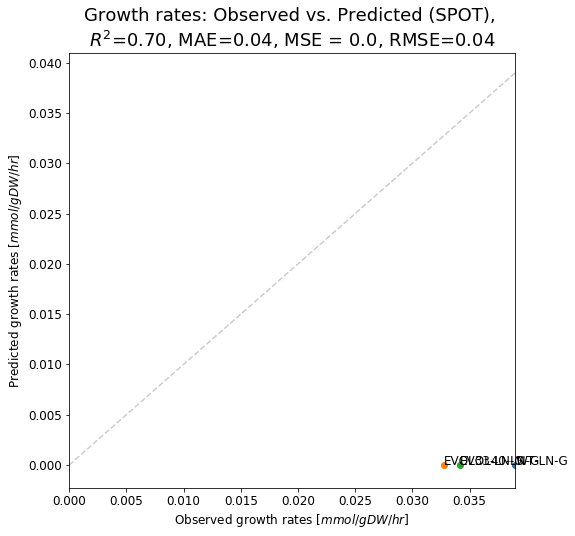

0.05634358030074359

{0.03274146524523911, 0.03415608108999895, 0.0390042421029697}

pandas.core.series.Series

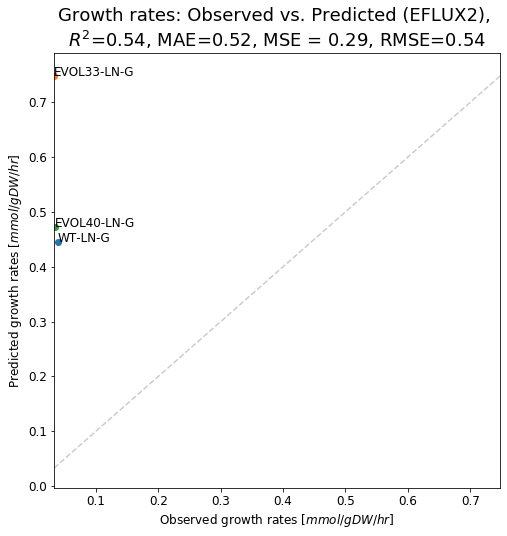

In [98]:
allindices=[str(row) for row in allgrowthrates.index]
scatterplotcompare(growthandsubstrdata.loc[allindices, 'growth_rate'], allgrowthrates.loc[:,'Growth_Glucose_SPOT'], allindices, 'SPOT')
scatterplotcompare(growthandsubstrdata.loc[allindices, 'growth_rate'], allgrowthrates.loc[:,'Growth_Glucose_EFLUX2'], allindices, 'EFLUX2')

In [93]:
allgrowthrates.to_csv('allgrowthratesGlucose.csv', index=True, header= True)